# Part 4 - CellViT Architectural Variants and Extensions

In this section, we evaluate four controlled decoder configurations built on SP-only VirTues embeddings.
All experiments share the same encoder, training setup, and data split.
Only decoder-level mechanisms are varied to isolate their effect.

In [1]:
import sys
import os
import warnings
warnings.filterwarnings("ignore", message=".*weights_only=False.*") # ignore warning from torch for loading models
os.environ["RAY_OBJECT_STORE_ALLOW_SLOW_STORAGE"] = "1" 
# 1. Get the path to the directory above the current one (i.e., the project root)
# os.getcwd() gives '.../project_root/notebook'
# '..' steps up to '.../project_root'
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))

if project_root not in sys.path:
    sys.path.insert(0, project_root)
    
from config import *
print(project_root)

import torch
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import pickle as pkl
from omegaconf import OmegaConf
from einops import rearrange
from tqdm import tqdm
import importlib

/data/code/jon/project-2-gradient_tri_scent


In [2]:
# project imports
from src.dataset.datasets.mm_base import build_mm_datasets, MultimodalDataset
from src.dataset.datasets.embeddings_dataset import EmbeddingsDataset # precomputed embeddings ds
from src.utils.plot_utils import visualize_multichannel_image
from src.modules.flex_dual_virtues.flex_dual_virtues_new_init import build_flex_dual_virtues_encoder
from src.utils.marker_utils import load_marker_embeddings
from src.utils.utils import load_checkpoint_safetensors

2025-12-18 09:41:10.217 | INFO     | src.modules.flex_dual_virtues.flex_dual_virtues_new_init:<module>:23 - Using flash attention for FlexDualVirTues


### Overview of Configurations

We evaluate the following configurations:

SP only
Baseline CellViT decoder using SP embeddings only.
No boundary supervision, no masked attention, no global context.

SP + boundary
Adds an auxiliary boundary prediction branch.
Boundary logits are trained jointly to encourage sharper object delineation.

SP + boundary + masked attention
Extends the boundary model with masked self-attention at the final decoder stage.
Attention is restricted to foreground regions using the predicted foreground mask.

SP + boundary + global context
Replaces masked attention with a global context attention block applied at the bottleneck.
This allows long-range spatial interactions before upsamplin

## Decoder Variant Evaluation (2-Fold, 100 Epochs)

Each decoder configuration is trained independently on **two fixed folds**
for **100 epochs per fold**.  
For every run, we store training loss, validation loss, and validation Dice
scores at each epoch in a `.npz` file.

This allows us to:
- visualize convergence behavior (loss & Dice curves),
- compare stability across folds,
- and report **mean ± standard deviation Dice** per configuration.

All results shown below are computed **post hoc** from the saved metric files,
without rerunning any experiments.


## Boundary Supervision

When boundary_attention=True, an additional upsampling branch predicts a 1-channel boundary map.
This branch shares the same decoder structure as the nuclei type head and is trained jointly.

Boundary supervision provides an explicit geometric signal that complements semantic classification.

We further explored 

In [5]:
import os
import numpy as np
from collections import defaultdict

checkpoint_dir = os.path.join(project_root, "notebooks", "checkpoints")

runs = []

for fname in os.listdir(checkpoint_dir):
    if not (fname.startswith("metrics_") and fname.endswith(".npz")):
        continue

    # Example:
    # metrics_fold1_SP_+_boundary_+_global_context.npz
    base = fname.replace("metrics_", "").replace(".npz", "")
    fold, experiment = base.split("_", 1)

    data = np.load(os.path.join(checkpoint_dir, fname))

    runs.append({
        "fold": fold,
        "experiment": experiment.replace("_", " "),
        "train_losses": data["train_losses"],
        "val_losses": data["val_losses"],
        "val_dices": data["val_dices"],
    })

print(f"Loaded {len(runs)} runs")

by_experiment = defaultdict(list)

for r in runs:
    by_experiment[r["experiment"]].append(r)

for exp, rs in by_experiment.items():
    print(f"{exp:35s} -> {len(rs)} folds")



Loaded 8 runs
SP + boundary + global context      -> 2 folds
SP only (baseline)                  -> 2 folds
SP only + boundary                  -> 2 folds
SP + boundary + masked              -> 2 folds


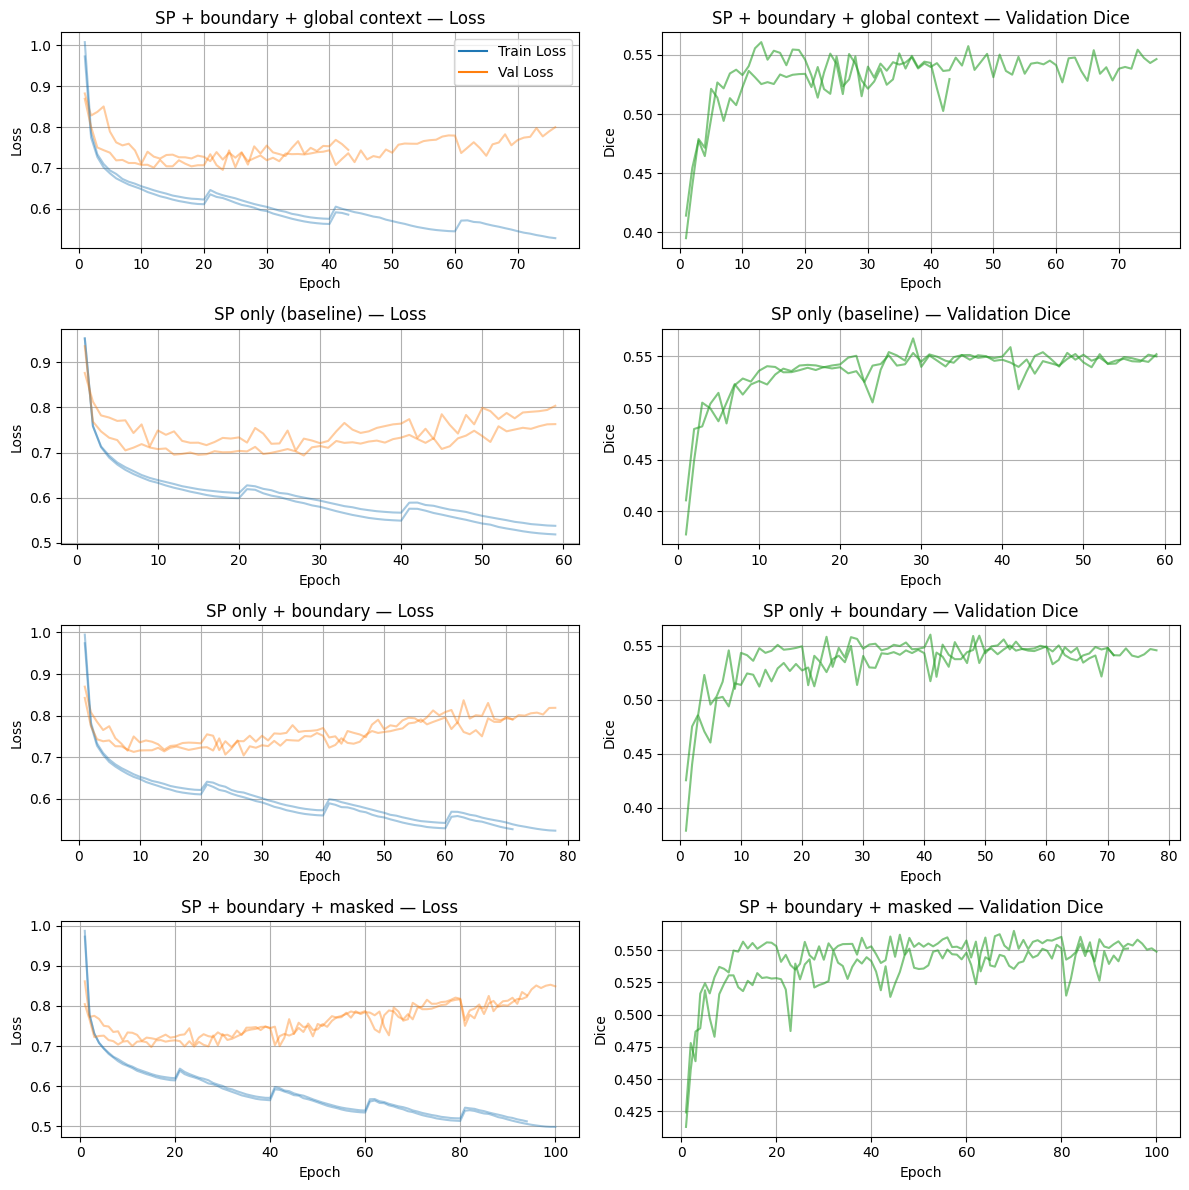

In [10]:
# Clean multi-panel plots: one row per experiment
# Left: Train & Val Loss | Right: Validation Dice
# Lines stop naturally due to early stopping

import numpy as np
import matplotlib.pyplot as plt

experiments = list(by_experiment.keys())
n_exp = len(experiments)

fig, axes = plt.subplots(
    nrows=n_exp,
    ncols=2,
    figsize=(12, 3 * n_exp),
    sharex=False
)

if n_exp == 1:
    axes = np.array([axes])  # normalize shape

for i, exp_name in enumerate(experiments):
    runs = by_experiment[exp_name]

    ax_loss = axes[i, 0]
    ax_dice = axes[i, 1]

    # ---- LOSS PLOTS ----
    for r in runs:
        epochs = np.arange(1, len(r["train_losses"]) + 1)
        ax_loss.plot(epochs, r["train_losses"], color="tab:blue", alpha=0.4)
        ax_loss.plot(epochs, r["val_losses"],   color="tab:orange", alpha=0.4)

    ax_loss.set_title(f"{exp_name} — Loss")
    ax_loss.set_xlabel("Epoch")
    ax_loss.set_ylabel("Loss")
    ax_loss.grid(True)

    # Legend only once
    if i == 0:
        ax_loss.plot([], [], color="tab:blue", label="Train Loss")
        ax_loss.plot([], [], color="tab:orange", label="Val Loss")
        ax_loss.legend()

    # ---- DICE PLOTS ----
    for r in runs:
        epochs = np.arange(1, len(r["val_dices"]) + 1)
        ax_dice.plot(epochs, r["val_dices"], color="tab:green", alpha=0.6)

    ax_dice.set_title(f"{exp_name} — Validation Dice")
    ax_dice.set_xlabel("Epoch")
    ax_dice.set_ylabel("Dice")
    ax_dice.grid(True)

plt.tight_layout()
plt.show()


In [11]:
# Summary table: Mean / Max / Std of best Dice across folds

import numpy as np
import pandas as pd

rows = []

for exp_name, runs in by_experiment.items():
    best_dices = [np.max(r["val_dices"]) for r in runs]

    rows.append({
        "Configuration": exp_name,
        "Mean Dice": np.mean(best_dices),
        "Max Dice":  np.max(best_dices),
        "Std Dice":  np.std(best_dices),
    })

df = pd.DataFrame(rows).sort_values("Mean Dice", ascending=False)

df


,Configuration,Mean Dice,Max Dice,Std Dice
3,SP + boundary + masked,0.562432,0.565016,0.002584
1,SP only (baseline),0.560321,0.567380,0.007060
2,SP only + boundary,0.559659,0.560269,0.000610
0,SP + boundary + global context,0.559189,0.560882,0.001693
